# Sparkify Project

In this workspace I use a mini subset (98MB) of the full dataset (12GB) to explore data with Spark and build the model before deploying a cluster processing the full dataset on the cloud.

In [1]:
# import libraries
from pyspark.sql import SparkSession, Window
from pyspark.sql.types import StringType, IntegerType
from pyspark.sql.functions import avg, explode, concat, lit, min, max, split, udf, isnull, col, desc

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from datetime import datetime
from time import time
import numpy as np

from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import GBTClassifier, RandomForestClassifier, LinearSVC
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [2]:
# create a Spark session
spark = SparkSession \
        .builder \
        .appName("mysparkify") \
        .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
data_path = 'data/mini_sparkify_event_data.json'
df = spark.read.json(data_path)

# See the frame schema
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [4]:
df.head(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')]

In [5]:
# Drop missing userId and sessionId
df = df.dropna(how = 'any', subset = ['userId','sessionId'])
df = df[df.userId != ""]

In [6]:
print("The number of rows in the dataframe is {}".format(df.count()))
print("The number of columns in the dataframe is {}".format(len(df.columns)))

The number of rows in the dataframe is 213745
The number of columns in the dataframe is 18


# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

In [7]:
# No of unique users in the data set
df.select("userId").dropDuplicates().count()

175

In [8]:
# No of unique sessions the data iset
df.select("sessionId").dropDuplicates().count()

2235

In [9]:
# User activities
df.select('page').dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

In [10]:
# add downgrade flag, 1 or 0
is_downgrade = udf(lambda x: int(x=="Submit Downgrade"), IntegerType())
df = df.withColumn("downgrade", is_downgrade("page"))

# add downgrade user flag
df = df.withColumn("user_downgrade", max("downgrade").over(Window.partitionBy("UserId")))

# add churn, 1 or 0
is_churn = udf(lambda x: int(x=="Cancellation Confirmation"), IntegerType())
df = df.withColumn("churn", is_churn("page"))

# add churn user flag
df = df.withColumn("user_churn", max('churn').over(Window.partitionBy('UserId')))

In [11]:
# Convert timestamp format
convert_ts = udf(lambda x: datetime.fromtimestamp(x / 1000.0).strftime("%m-%d-%Y %H:%M:%S"))
df = df.withColumn('registration_datetime', convert_ts('registration'))
df = df.withColumn('event_datetime', convert_ts('ts'))

In [12]:
df.head(1)

[Row(artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', downgrade=0, user_downgrade=0, churn=0, user_churn=0, registration_datetime='09-27-2018 02:45:40', event_datetime='10-08-2018 12:58:54')]

In [13]:
df.select(['userId', 'firstName','level', 'registration_datetime' ,'user_churn', 'user_downgrade']).dropDuplicates(['userId']).show(10)
      

+------+---------+-----+---------------------+----------+--------------+
|userId|firstName|level|registration_datetime|user_churn|user_downgrade|
+------+---------+-----+---------------------+----------+--------------+
|100010| Darianna| free|  09-27-2018 02:45:40|         0|             0|
|   125|    Mason| free|  08-01-2018 20:58:59|         1|             0|
|   124|   Nicole| paid|  07-22-2018 01:52:15|         0|             0|
|    51|    Ethan| paid|  09-27-2018 20:43:07|         1|             0|
|     7|   Maddox| free|  09-11-2018 12:06:16|         0|             0|
|    15|    Panav| paid|  09-29-2018 16:37:25|         0|             0|
|    54|    Alexi| paid|  07-25-2018 01:37:42|         1|             1|
|   155|   Camila| free|  11-04-2018 22:27:50|         0|             0|
|100014|  Rodrigo| paid|  08-27-2018 17:04:03|         0|             0|
|   132|    Sadie| free|  09-15-2018 23:35:53|         0|             0|
+------+---------+-----+---------------------+-----

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

#### Churn users by genders

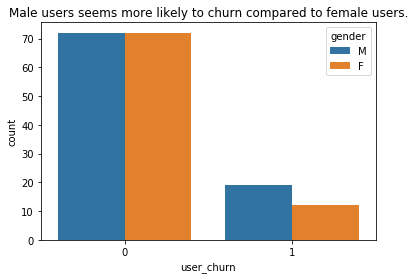

In [14]:
# Plotting a bar plot to show gender distribution between regular and churn users
df_ch_pd = df.drop_duplicates(['userId', 'gender']).groupby(['user_churn', 'gender']).count().sort("user_churn").toPandas()
plt.title('Male users seems more likely to churn compared to female users.')
sns.barplot(x = 'user_churn', y = 'count', data = df_ch_pd, hue = 'gender')

#### Paid/Free customers churn

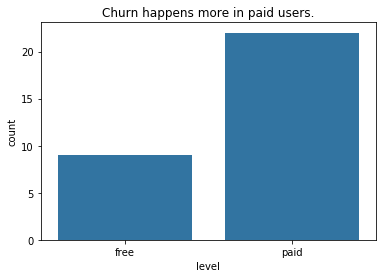

In [15]:
df_level_pd = df.filter('page == "Cancellation Confirmation"').groupby('level').count().toPandas()
plt.title('Churn happens more in paid users.')
sns.barplot(data = df_level_pd, x = 'level', y = 'count', color = sns.color_palette()[0])

#### Number of songs played per session

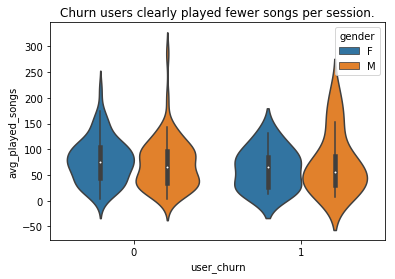

In [16]:
avg_songs_df = df.where('page == "NextSong"').groupby(['user_churn', 'userId', 'sessionId', 'gender']).count()\
    .groupby(['user_churn', 'userId', 'gender']).agg({'count': 'avg'})\
    .withColumnRenamed('avg(count)', 'avg_played_songs').toPandas()
plt.title('Churn users clearly played fewer songs per session.')
sns.violinplot('user_churn', y = 'avg_played_songs', hue = 'gender', data = avg_songs_df)

#### Time since registration

In [17]:
df_lt = df.select('userId','registration','ts','user_churn') \
    .withColumn('lifetime',(df.ts-df.registration)) \
    .groupBy('userId','user_churn') \
    .agg({'lifetime':'max'}) \
    .withColumnRenamed('max(lifetime)','lifetime') \
    .select('userId', 'user_churn', (col('lifetime')/1000/3600/24).alias('lifetime')) \
    .toPandas()

Text(0.5,1,'Churn users use the services in shorter period of time.')

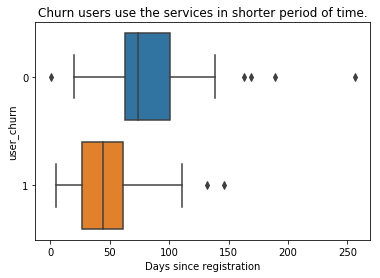

In [18]:
sns.boxplot(data=df_lt, y='user_churn', x='lifetime', orient='h')
plt.xlabel('Days since registration')
plt.ylabel('user_churn')
plt.title('Churn users use the services in shorter period of time.')

#### How many friends 

In [19]:
df_friends = df.where('page == "Add Friend"').groupby(['user_churn', 'userId', 'gender']).count()\
    .groupby(['user_churn', 'userId', 'gender']).agg({'count': 'avg'})\
    .withColumnRenamed('avg(count)', 'avg_friends').toPandas()

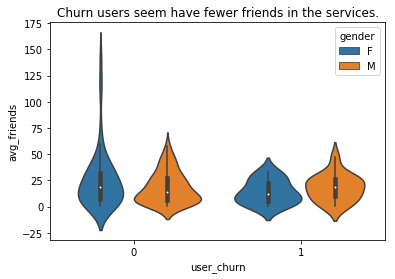

In [20]:
plt.title('Churn users seem have fewer friends in the services.')
sns.violinplot('user_churn', y = 'avg_friends', hue = 'gender', data = df_friends)

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. Extract features based on the small subset of data contained here. Be sure to transfer over this work to the full dataset when you work on your Spark cluster.

### Create new features
1. Total songs listened
2. Number of thumbs up
3. Number of thumbs up
4. Total time since registration
5. Average songs played per session
6. Number of songs added to playlist
7. Total number of friends
8. Downgrade (categorical variables)

### Setting target variable
1. Churn

In [21]:
# Total songs listened
total_songs_listened = df.select('userId', 'song').groupBy('userId').count().withColumnRenamed('count', 'total_songs_listened')
total_songs_listened.show(5)

+------+--------------------+
|userId|total_songs_listened|
+------+--------------------+
|100010|                 104|
|   125|                  11|
|    51|                2464|
|   124|                4825|
|     7|                 201|
+------+--------------------+
only showing top 5 rows



In [22]:
# Number of thumbs up
num_thumbs_up = df.select('userId', 'page').where(df.page == 'Thumbs Up').groupBy('userId').count().withColumnRenamed('count', 'num_thumbs_up')
num_thumbs_up.show(5)

+------+-------------+
|userId|num_thumbs_up|
+------+-------------+
|100010|            4|
|    51|          100|
|   124|          171|
|     7|            7|
|    54|          163|
+------+-------------+
only showing top 5 rows



In [23]:
# Number of thumbs up
num_thumbs_down = df.select('userId', 'page').where(df.page == 'Thumbs Down').groupBy('userId').count().withColumnRenamed('count', 'num_thumbs_down')
num_thumbs_down.show(5)

+------+---------------+
|userId|num_thumbs_down|
+------+---------------+
|100010|              1|
|    51|             21|
|   124|             41|
|     7|              1|
|    15|             14|
+------+---------------+
only showing top 5 rows



In [24]:
# Total time since registration
total_lifetime = df.select('userId', 'registration', 'ts').withColumn('total_lifetime', (df.ts - df.registration))\
    .groupBy('userId').agg({'total_lifetime' : 'max'})\
    .withColumnRenamed('max(total_lifetime)', 'total_lifetime')\
    .select('userId', (col('total_lifetime')/1000/3600/24).alias('total_lifetime'))
total_lifetime.show(5)

+------+------------------+
|userId|    total_lifetime|
+------+------------------+
|100010|19.578518518518518|
|   125| 71.31688657407408|
|    51|19.455844907407407|
|   124|131.55591435185184|
|     7| 72.77818287037037|
+------+------------------+
only showing top 5 rows



In [25]:
# Average songs played per session
avg_song_played = df.where('page == "NextSong"').groupby(['userId', 'sessionId']).count().groupby(['userId']).agg({'count':'avg'}).withColumnRenamed('avg(count)', 'avg_songs_played')
avg_song_played.show(5)

+------+------------------+
|userId|  avg_songs_played|
+------+------------------+
|100010|25.333333333333332|
|   125|               8.0|
|    51|             211.1|
|   124|145.67857142857142|
|     7|21.428571428571427|
+------+------------------+
only showing top 5 rows



In [26]:
# Number of songs added to playlist
add_to_playlist = df.select('userID','page').where(df.page == 'Add to Playlist').groupBy('userID').count().withColumnRenamed('count', 'add_to_playlist')
add_to_playlist.show(5)

+------+---------------+
|userID|add_to_playlist|
+------+---------------+
|100010|              1|
|    51|             52|
|   124|            118|
|     7|              5|
|    15|             59|
+------+---------------+
only showing top 5 rows



In [27]:
# Total number of friends
total_friends = df.select('userId', 'page').where(df.page == 'Add Friend').groupBy('userId').count().withColumnRenamed('count', 'total_friends')
total_friends.show()

+------+-------------+
|userId|total_friends|
+------+-------------+
|100010|            1|
|    51|           28|
|   124|           74|
|     7|            1|
|    54|           33|
|    15|           31|
|   155|           11|
|   132|           41|
|   154|            3|
|100014|            4|
|   101|           29|
|    11|            6|
|   138|           41|
|    29|           47|
|    69|           12|
|100021|            2|
|    42|           52|
|   112|            7|
|    73|           11|
|    87|           27|
+------+-------------+
only showing top 20 rows



In [28]:
# Label downgrade users
downgrade = df.select('userId', 'user_downgrade').dropDuplicates().select('userId', col('user_downgrade').cast('int'))
downgrade.show(5)

+------+--------------+
|userId|user_downgrade|
+------+--------------+
|100010|             0|
|   125|             0|
|   124|             0|
|    51|             0|
|     7|             0|
+------+--------------+
only showing top 5 rows



In [29]:
# churn label as target variable
churn = df.select('userId', 'user_churn').dropDuplicates()
churn.show(5)

+------+----------+
|userId|user_churn|
+------+----------+
|100010|         0|
|   125|         1|
|   124|         0|
|    51|         1|
|     7|         0|
+------+----------+
only showing top 5 rows



In [30]:
def features_merge(df1, df2):
    """  
    INPUT: 
    df1 - dataframe to be merged
    df2 - dataframe to be merged and remove its key
    
    OUTPUT: 
    df - merged dataframe
    
    Description: 
    This function is used to merge the feature using left join. 
    """
    
    df2 = df2.withColumnRenamed("userId", "userId_dup")
    df = df1.join(df2, df1.userId == df2.userId_dup, "left").drop("userId_dup")
    return df

In [31]:
features_list = [total_songs_listened, num_thumbs_up, num_thumbs_down, total_lifetime, avg_song_played, add_to_playlist, total_friends, downgrade]

In [32]:
# setting the churn label for the model
target = df.select('userId', col('user_churn').alias('target')).dropDuplicates()
target.show(5)

+------+------+
|userId|target|
+------+------+
|100010|     0|
|   125|     1|
|   124|     0|
|    51|     1|
|     7|     0|
+------+------+
only showing top 5 rows



In [33]:
df_final = target

for feature in features_list:
    df_final = features_merge(df_final, feature)

In [34]:
df_final = df_final.na.fill(0)
df_final = df_final.orderBy('userId', ascending=True)
df_final.head(5)

[Row(userId='10', target=0, total_songs_listened=795, num_thumbs_up=37, num_thumbs_down=4, total_lifetime=51.76265046296297, avg_songs_played=112.16666666666667, add_to_playlist=9, total_friends=12, user_downgrade=0),
 Row(userId='100', target=0, total_songs_listened=3214, num_thumbs_up=148, num_thumbs_down=27, total_lifetime=64.87377314814815, avg_songs_played=78.88235294117646, add_to_playlist=61, total_friends=49, user_downgrade=1),
 Row(userId='100001', target=1, total_songs_listened=187, num_thumbs_up=8, num_thumbs_down=2, total_lifetime=44.80021990740741, avg_songs_played=33.25, add_to_playlist=3, total_friends=2, user_downgrade=0),
 Row(userId='100002', target=0, total_songs_listened=5, num_thumbs_up=0, num_thumbs_down=0, total_lifetime=105.3844675925926, avg_songs_played=3.0, add_to_playlist=1, total_friends=0, user_downgrade=0),
 Row(userId='100003', target=1, total_songs_listened=78, num_thumbs_up=3, num_thumbs_down=0, total_lifetime=22.748113425925926, avg_songs_played=25.5,

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

### Vectorize all features

In [35]:
features_vectorize = VectorAssembler(inputCols=df_final.columns[2:], outputCol='features_vector')
df_final = features_vectorize.transform(df_final)

In [36]:
df_final.head()

Row(userId='10', target=0, total_songs_listened=795, num_thumbs_up=37, num_thumbs_down=4, total_lifetime=51.76265046296297, avg_songs_played=112.16666666666667, add_to_playlist=9, total_friends=12, user_downgrade=0, features_vector=DenseVector([795.0, 37.0, 4.0, 51.7627, 112.1667, 9.0, 12.0, 0.0]))

### Standardizing all features

In order to avoid one feature with larger scale dominant the whole model, we need to standardize the features

In [37]:
scaler = StandardScaler(inputCol = 'features_vector', outputCol = "standard_features", withMean=True, withStd=True)
feature_standardize = scaler.fit(df_final)
df_final = feature_standardize.transform(df_final)

In [38]:
df_final.head()

Row(userId='10', target=0, total_songs_listened=795, num_thumbs_up=37, num_thumbs_down=4, total_lifetime=51.76265046296297, avg_songs_played=112.16666666666667, add_to_playlist=9, total_friends=12, user_downgrade=0, features_vector=DenseVector([795.0, 37.0, 4.0, 51.7627, 112.1667, 9.0, 12.0, 0.0]), standard_features=DenseVector([-0.3128, -0.2362, -0.4773, -0.6194, 0.8239, -0.5875, -0.3283, -0.4807]))

In [39]:
data = df_final.select(df_final.target.alias("label"), df_final.standard_features.alias("features"))
data.show(5)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    0|[-0.3128242518367...|
|    0|[1.46185179223729...|
|    1|[-0.7588775940430...|
|    0|[-0.8924001405587...|
|    1|[-0.8388443938794...|
+-----+--------------------+
only showing top 5 rows



In [40]:
train, test = data.randomSplit([0.6, 0.4], seed=42)

In [41]:
train.groupby("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|   17|
|    0|   94|
+-----+-----+



In [42]:
test.groupby("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|   14|
|    0|   50|
+-----+-----+



### Baseline Model

Set an baseline model, with all users labelled as churn = 0, and calculated the model accuracy and f1 score. We shall expect the high score because the churned users are a fairly small subset.

In [43]:
def evaluate_performance(model_result, model_name, start, end):
    evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
    print('{} performance metrics:'.format(model_name))
    print('Accuracy: {}'.format(evaluator.evaluate(model_result, {evaluator.metricName: "accuracy"})))
    print('F-1 Score:{}'.format(evaluator.evaluate(model_result, {evaluator.metricName: "f1"})))
    print('Total training time: {} seconds'.format(end - start))

In [44]:
baseline = test.withColumn('prediction', lit(0.0))

In [45]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print('Baseline model metrics:')
print('Accuracy: {}'.format(evaluator.evaluate(baseline, {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(baseline, {evaluator.metricName: "f1"})))

Baseline model metrics:
Accuracy: 0.78125
F-1 Score:0.6853070175438596


### Random Forest

In [46]:
rf = RandomForestClassifier(seed = 42)

f1_evaluation = MulticlassClassificationEvaluator(metricName = 'f1')

param_grid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 20]) \
    .addGrid(rf.maxDepth, [10, 20]) \
    .build()

rf_cv = CrossValidator(estimator = rf, estimatorParamMaps = param_grid, evaluator = f1_evaluation, numFolds = 2)

In [47]:
start = time()
rf_cv_model = rf_cv.fit(train)
end = time()
rf_cv_model.avgMetrics

[0.760262618737195, 0.760262618737195, 0.7682556766869786, 0.7682556766869786]

In [48]:
results_rf = rf_cv_model.transform(test)

In [49]:
evaluate_performance(results_rf, "Random Forest", start, end)

Random Forest performance metrics:
Accuracy: 0.78125
F-1 Score:0.7456018518518519
Total training time: 533.6691846847534 seconds


### Gradient Boosted Trees

In [50]:
gbt = GBTClassifier(seed = 42)

f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')

param_grid = ParamGridBuilder() \
    .addGrid(gbt.maxIter, [10, 20]) \
    .addGrid(gbt.maxDepth, [10, 20]) \
    .build()

gbt_cv = CrossValidator(estimator = gbt, estimatorParamMaps = param_grid, evaluator = f1_evaluator, numFolds = 2)

In [51]:
start = time()
gbt_cv_model = gbt_cv.fit(train)
end = time()
gbt_cv_model.avgMetrics

[0.7345120411959689,
 0.7345120411959689,
 0.7345120411959689,
 0.7345120411959689]

In [52]:
results_gbt = gbt_cv_model.transform(test)

In [53]:
evaluate_performance(results_gbt, "Gradient Boosted Trees", start, end)

Gradient Boosted Trees performance metrics:
Accuracy: 0.734375
F-1 Score:0.7307709937660432
Total training time: 1867.8603122234344 seconds


### Support Vector Machine 

In [54]:
svm = LinearSVC()

f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')

paramGrid = ParamGridBuilder() \
    .addGrid(svm.maxIter, [10, 20]) \
    .build()

svm_cv = CrossValidator(estimator=svm, estimatorParamMaps=paramGrid, evaluator=f1_evaluator, numFolds = 2)

In [55]:
start = time()
svm_cv_model = svm_cv.fit(train)
end = time()
svm_cv_model.avgMetrics

[0.7801888207061205, 0.7991685739755546]

In [56]:
results_svm = svm_cv_model.transform(test)

In [57]:
evaluate_performance(results_svm, "Support Vector Machine", start, end)

Support Vector Machine performance metrics:
Accuracy: 0.78125
F-1 Score:0.6853070175438596
Total training time: 775.3471856117249 seconds


### Evaluate models

Performance ranking:

1. Random Forest has F1 score 0.746, Accuracy 0.781
2. Gradient Boosted Trees has F1 score 0.731, Accuracy 0.734
3. Support Vector Machine has F1 score of 0.685, Accuracy 0.781

As we optimized based on F1, Random Forest is the best model.

#### Feature Importance of best model

Text(0,0.5,'Features')

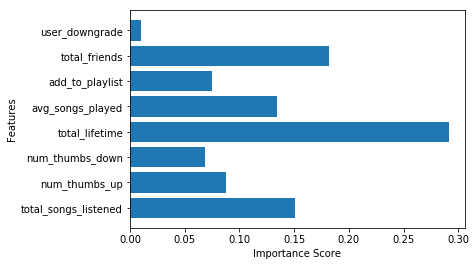

In [58]:
feat_imp_val = rf_cv_model.bestModel.featureImportances.values
cols = ["total_songs_listened", "num_thumbs_up", "num_thumbs_down", \
        'total_lifetime','avg_songs_played', 'add_to_playlist', 'total_friends', 'user_downgrade']

y_pos = np.arange(len(cols))
 
plt.barh(y_pos, feat_imp_val, align='center')
plt.yticks(y_pos, cols)
plt.xlabel('Importance Score')
plt.ylabel('Features')

# Conclusion

### Summary

In this project, I implemented a model to predict customer churn for Sparkify music streaming services. I explore the data set to get some ideas of what features might matter, and create or transform features for modeling process. Here I evaluate 3 models: Random Forest (RF), Gradient Boosted Trees (GBT), and Support Vector Machine (SVM). The tuned RF model is able to achieve about F1 score 0.746, which still outperforms the baseline model - predicting everyone not churn, with F1 score of 0.685, though its performance is actually inflated due to the imbalance of data set. Based on F1 score, the final model has 9% improvement compared to the baseline model.

### Reflection

This project gives me the exposure to build machine learing models on Apache Spark which I don't have much experience before. I believe it's a great learning to practice on PySpark and learning  big data ecosystem to process data in a scalable way.

Furthermore, customer churn is a common and critical issues for services company to become profitable. I follow the CRISP methodology in this project, understand business problem, explore data, and eventually come up with some idea of features for modeling. It's a great journey to go through all of the steps in a data science project.

### Improvement

The model performance could be better and more reliable with larger data size since there are only 175 unique users in the mini data set.

The features can also be improved if considering more factors or adding more domain knowledge. It evolves as the company grows its user base and excavates more insights from data.